Loading database at ../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset1...
Loading database at ../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset2...
Loading database at ../datasets/rc_car/Stanmer_park_dataset/0511/unwrapped_dataset3...


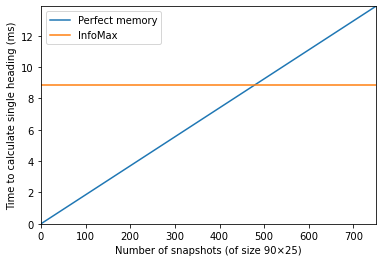

In [16]:
import sys
sys.path.append("..")

import os
import matplotlib.pyplot as plt
import navbench as nb
import yaml

DB_ROOT = "../datasets/rc_car/Stanmer_park_dataset"

def read_yaml(filepath):
    file = open(filepath, "r")
    file.readline()
    file.readline()
    data = yaml.full_load(file)["data"]
    file.close()
    return data

def load_databases(routes):
    return [nb.Database(os.path.join(DB_ROOT, route)) for route in routes[0]]


data_pm = read_yaml("benchmark_pm.yaml")
im_size = data_pm["image_size"]
pm_test_time = data_pm["testing"]["time_per_image_ms"]

train_dbs = load_databases(data_pm["training"]["routes"])
test_dbs = load_databases(data_pm["testing"]["routes"])

num_snapshots = 0
for db in train_dbs:
    num_snapshots += len(db)
# pm_op_time = pm_test_time / (im_size[0] * im_size[1] * num_snapshots)
pm_test_time_per_snap = pm_test_time / num_snapshots

data_infomax = read_yaml("benchmark_infomax.yaml")
infomax_test_time = data_infomax["testing"]["time_per_image_ms"]
# infomax_op_time = infomax_test_time / ((im_size[0] * im_size[1]) ** 2)

_, ax = plt.subplots()
x = range(751)
ax.plot(x, [val * pm_test_time_per_snap for val in x])
ax.plot(x, len(x) * [infomax_test_time])
ax.autoscale(tight=True)
ax.set_xlabel('Number of snapshots (of size %i×%i)' % (im_size[0], im_size[1]))
ax.set_ylabel('Time to calculate single heading (ms)')
ax.legend(['Perfect memory', 'InfoMax']);

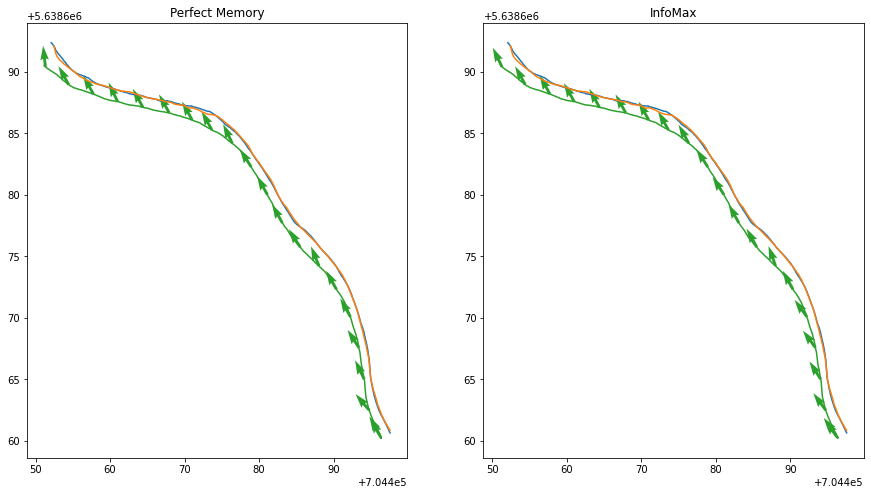

In [17]:
import numpy as np

STEP = 20

heading_offset = test_dbs[0].calculate_heading_offset(0.25)

def plot_headings(ax, data, title):
    lines = []
    for db in [*train_dbs, test_dbs[0]]:
        lines.append(ax.plot(db.x, db.y))

    headings = np.array(data["testing"]["headings_deg"][0])
    headings = np.radians(headings)
    headings += heading_offset

    u = np.cos(headings[::STEP])
    v = np.sin(headings[::STEP])
    ax.quiver(db.x[::STEP], db.y[::STEP], u, v, angles='xy', color=lines[-1][0].get_color())
    ax.set_title(title)
    return headings

_, axes = plt.subplots(1, 2, figsize=(15, 8))
headings_pm = plot_headings(axes[0], data_pm, "Perfect Memory")
headings_infomax = plot_headings(axes[1], data_infomax, "InfoMax")

Mean errors for perfect memory: 19.3511 (+-13.1998) deg
Errors over 30°: 28.1095%
Mean errors for InfoMax: 21.3627 (+-13.3506) deg
Errors over 30°: 34.0796%


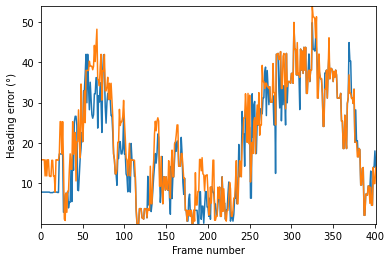

In [18]:
import math

ERROR_THRESH_DEG = 30

test_pos = test_dbs[0].position

def circ_distance(x, y):
    r = (y - x) % math.tau
    while (r > math.pi):
        r -= math.tau
    return r

def get_angular_errors(test_pos, test_headings):
    ref_db = train_dbs[0]
    ref_heads = np.arctan2(np.diff(ref_db.y), np.diff(ref_db.x))
    ref_heads = np.append(ref_heads, ref_heads[-1])
    errs = []
    for row in range(test_pos.shape[0]):
        distances = [np.linalg.norm(ref_db.position[entry, 0:2] - test_pos[row, 0:2]) for entry in range(len(ref_db))]
        nearest_entry = np.argmin(distances)
        ang_dist = circ_distance(test_headings[row], ref_heads[nearest_entry])
        errs.append(abs(ang_dist))
    return np.array(errs)

def print_info(label, errs):
    mean = math.degrees(np.mean(errs))
    std = math.degrees(np.std(errs))
    print('Mean errors for %s: %g (+-%g) deg' % (label, mean, std))
    prop = np.mean(errs > math.radians(ERROR_THRESH_DEG))
    print('Errors over %g°: %g%%' % (ERROR_THRESH_DEG, 100 * prop))

errs_pm = get_angular_errors(test_pos, headings_pm)
errs_infomax = get_angular_errors(test_pos, headings_infomax)

print_info('perfect memory', errs_pm)
print_info('InfoMax', errs_infomax)

_, ax = plt.subplots()
ax.plot(np.degrees(errs_pm))
ax.plot(np.degrees(errs_infomax))
ax.set_ylabel('Heading error (°)')
ax.set_xlabel('Frame number')
ax.autoscale(tight=True)